# Midiendo rendimiento y riesgo con datos históricos

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/7/7d/Copper_Price_History_USD.png" width="600px" height="400px" />

> Ya sabemos que podemos caracterizar la distribución de rendimientos de un activo mediante una medida de tendencia central (media: rendimiento esperado) y una medida de dispersión (desviación estándar: volatilidad). 

> En la clase pasada vimos como obtener reportes históricos de precios de activos. ¿Cómo usamos estos históricos para medir el rendimiento esperado y la volatilidad de los rendimientos?

*Objetivos:*
- Calcular los rendimientos a partir de históricos de precios.
- Estimar rendimiento esperado y riesgo a partir de históricos de rendimientos.
- Anualizar rendimiento y volatilidad cuando los datos están en una base de tiempo menor.
- Verificar la relación entre rendimiento y riesgo a través de datos reales.

**Referencias:**
- http://pandas.pydata.org/
- https://pandas-datareader.readthedocs.io/en/latest/
- Notas del curso "Portfolio Selection and Risk Management", Rice University, disponible en Coursera.
___

## 1. Cálculo de los rendimientos

Muy bien, ya entonces sabemos descargar históricos de precios...

**Ejemplo:** trabajaremos esta clase con activos que se encuentran en el top-10 del índice S&P500. Descargar precios ajustados en el cierre de Microsoft (MSFT), Apple (AAPL), Amazon (AMZN), Facebook (META) y Alphabet Inc. (GOOGL) desde el primero de enero del 2015 hasta hoy.

In [1]:
# Importar paquetes
import pandas_datareader.data as web
import yfinance as yf
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
yf.pdr_override()

In [3]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers,
                   start_date=None,
                   end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.get_data_yahoo(
        tickers=tickers,
        start=start_date,
        end=end_date
    )
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [4]:
# Información
tickers = ["MSFT", "AAPL", "AMZN", "META", "GOOGL"]
start_date = "2015-01-01"

In [5]:
# Precios diarios ajustados en el cierre
closes = get_adj_closes(
    tickers=tickers,
    start_date=start_date
)

[*********************100%***********************]  5 of 5 completed


In [6]:
closes.head()

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2015-01-02 00:00:00-05:00,24.603205,15.4260,26.477501,78.449997,40.811440
2015-01-05 00:00:00-05:00,23.910095,15.1095,25.973000,77.190002,40.436138
2015-01-06 00:00:00-05:00,23.912342,14.7645,25.332001,76.150002,39.842648
2015-01-07 00:00:00-05:00,24.247641,14.9210,25.257500,76.150002,40.348858
2015-01-08 00:00:00-05:00,25.179300,15.0230,25.345501,78.180000,41.535839


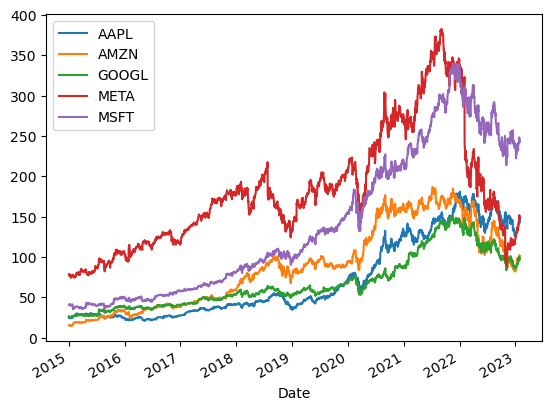

In [7]:
# Gráfico de histórico de precios diarios
closes.plot();

### 1.1. Rendimientos porcentuales

Muy bien, pero para el análisis no trabajamos con los precios sino con los rendimientos... **¿porqué?**

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el el cambio porcentual
$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}
$$
para $t=1,\ldots,n$.

*¡Cuidado!* los rendimientos son de acuerdo a la base de tiempo en que se reportan los precios. Por ejemplo: 
- si los precios se reportan en una base diaria, los rendimientos también son diarios;
- si los precios se reportan en una base mensual, los rendimientos también son mensuales.

In [9]:
# S_t
closes.head()

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2015-01-02 00:00:00-05:00,24.603205,15.4260,26.477501,78.449997,40.811440
2015-01-05 00:00:00-05:00,23.910095,15.1095,25.973000,77.190002,40.436138
2015-01-06 00:00:00-05:00,23.912342,14.7645,25.332001,76.150002,39.842648
2015-01-07 00:00:00-05:00,24.247641,14.9210,25.257500,76.150002,40.348858
2015-01-08 00:00:00-05:00,25.179300,15.0230,25.345501,78.180000,41.535839


In [13]:
# S_{t-1}
closes.shift().head()

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2015-01-02 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN
2015-01-05 00:00:00-05:00,24.603205,15.4260,26.477501,78.449997,40.811440
2015-01-06 00:00:00-05:00,23.910095,15.1095,25.973000,77.190002,40.436138
2015-01-07 00:00:00-05:00,23.912342,14.7645,25.332001,76.150002,39.842648
2015-01-08 00:00:00-05:00,24.247641,14.9210,25.257500,76.150002,40.348858


In [19]:
# Calcular rendimientos
st = closes
st_1 = closes.shift()
ret = ((st - st_1) / st_1).dropna()

In [41]:
# Una forma equivalente de hacerlo
ret = closes.pct_change().dropna()

In [42]:
ret.tail()

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2023-01-24 00:00:00-05:00,0.010063,-0.012305,-0.020944,-0.000907,-0.002226
2023-01-25 00:00:00-05:00,-0.004701,0.008929,-0.025384,-0.011457,-0.005908
2023-01-26 00:00:00-05:00,0.014803,0.020992,0.024155,0.040989,0.030714
2023-01-27 00:00:00-05:00,0.013684,0.030437,0.018971,0.030143,0.000645
2023-01-30 00:00:00-05:00,-0.020078,-0.016530,-0.024454,-0.030842,-0.021962


In [20]:
ret.head()

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2015-01-05 00:00:00-05:00,-0.028172,-0.020517,-0.019054,-0.016061,-0.009196
2015-01-06 00:00:00-05:00,0.000094,-0.022833,-0.024679,-0.013473,-0.014677
2015-01-07 00:00:00-05:00,0.014022,0.010600,-0.002941,0.000000,0.012705
2015-01-08 00:00:00-05:00,0.038423,0.006836,0.003484,0.026658,0.029418
2015-01-09 00:00:00-05:00,0.001072,-0.011749,-0.012211,-0.005628,-0.008405


`NaN`: Not A Number

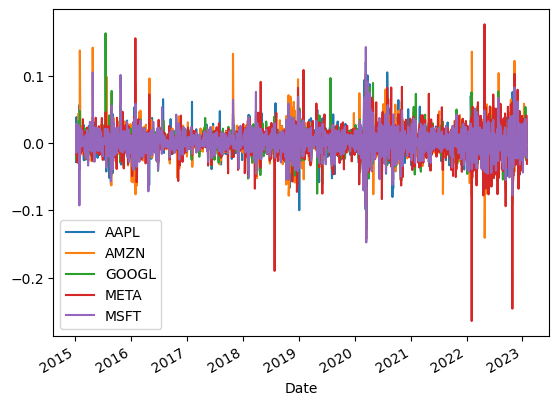

In [21]:
# Graficar...
ret.plot();

**¿Qué se observa respecto a los precios?**

Respuestas:
- Los rendimientos parecen conservar tendecias estadísticas constantes (por ejemplo, oscilan al rededor de números cercanos a cero). 

### 1.2. Rendimientos logarítmicos (log-rendimientos)

Otro rendimiento usado con frecuencia es el rendimiento continuamente compuesto o rendimiento logaritmico. Éste, está definido como

$$
r_t=\ln\left(\frac{S_t}{S_{t-1}}\right).
$$

Es fácil darse cuenta que $r_t=\ln(1+R_t)$.

<font color=blue>Ver en el tablero</font> que si $0\leq|x|\ll 1$, entonces $\ln(1+x)\approx x$.

In [27]:
%timeit np.log(st).diff()

87.2 µs ± 878 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [28]:
%timeit np.log(st / st_1)

127 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [29]:
# Más eficiente
logret = np.log(st).diff().dropna()

In [30]:
logret.head()

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2015-01-05 00:00:00-05:00,-0.028576,-0.020731,-0.019238,-0.016191,-0.009239
2015-01-06 00:00:00-05:00,0.000094,-0.023098,-0.024989,-0.013565,-0.014786
2015-01-07 00:00:00-05:00,0.013925,0.010544,-0.002945,0.000000,0.012625
2015-01-08 00:00:00-05:00,0.037703,0.006813,0.003478,0.026309,0.028994
2015-01-09 00:00:00-05:00,0.001072,-0.011818,-0.012286,-0.005644,-0.008441


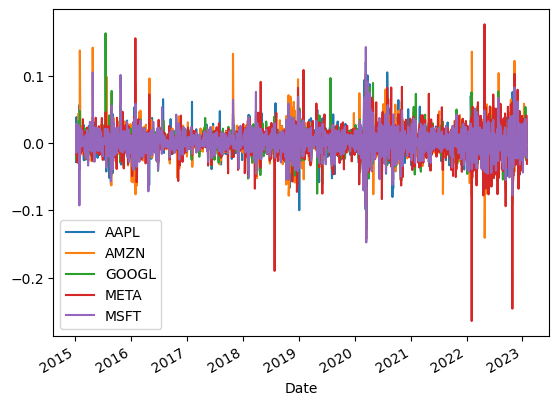

In [32]:
ret.plot();

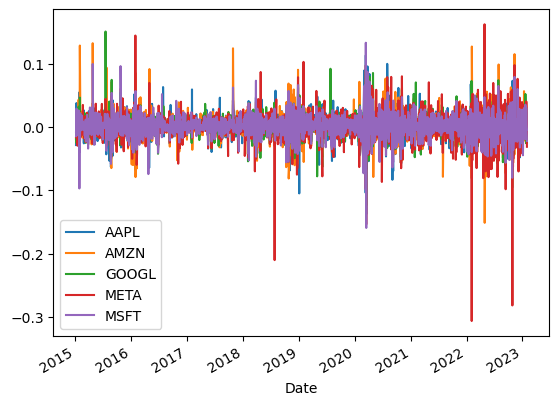

In [31]:
logret.plot();

In [33]:
# Recordar rendimientos porcentuales. Ver que son similares
np.abs(ret - logret)

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2015-01-05 00:00:00-05:00,4.044308e-04,0.000213,0.000184,1.303776e-04,4.254409e-05
2015-01-06 00:00:00-05:00,4.415003e-09,0.000265,0.000310,9.158795e-05,1.087762e-04
2015-01-07 00:00:00-05:00,9.739863e-05,0.000056,0.000004,0.000000e+00,8.003435e-05
2015-01-08 00:00:00-05:00,7.197725e-04,0.000023,0.000006,3.491306e-04,4.244049e-04
2015-01-09 00:00:00-05:00,5.745312e-07,0.000070,0.000075,1.589726e-05,3.552371e-05
...,...,...,...,...,...
2023-01-24 00:00:00-05:00,5.029544e-05,0.000076,0.000222,4.119472e-07,2.481455e-06
2023-01-25 00:00:00-05:00,1.108328e-05,0.000040,0.000328,6.614066e-05,1.752178e-05
2023-01-26 00:00:00-05:00,1.085004e-04,0.000217,0.000287,8.177938e-04,4.622221e-04


Por lo anterior, muchas veces se usan para el análisis los rendimientos continuamente compuestos.
___

## 2. Caracterización de la distribución de los rendimientos

Entonces:
- partimos de que tenemos los rendimientos porcentuales diarios de Microsoft (MSFT), Apple (AAPL), Amazon (AMZN), Facebook (FB) y Alphabet Inc. (GOOGL) desde inicios del 2011 a finales del 2015;
- ¿cómo resumirían estos datos?

In [34]:
# Rendimiento medio diario (media aritmética)
ret.mean()

AAPL     0.001044
AMZN     0.001142
GOOGL    0.000798
META     0.000592
MSFT     0.001035
dtype: float64

In [35]:
# Volatilidad diaria (desviación estándar)
ret.std()

AAPL     0.018847
AMZN     0.021011
GOOGL    0.017853
META     0.023463
MSFT     0.017756
dtype: float64

In [39]:
# Podemos resumir en un DataFrame
summary_daily = pd.DataFrame({
    "mean": ret.mean(),
    "vol": ret.std()
}).T
summary_daily

,AAPL,AMZN,GOOGL,META,MSFT
mean,0.001044,0.001142,0.000798,0.000592,0.001035
vol,0.018847,0.021011,0.017853,0.023463,0.017756


Normalmente se reportan rendimientos esperados y volatilidades en una base anual. Para anualizar:

$$E[r_a]=12E[r_m]=252E[r_d]=52E[r_w],\text{ y}$$

$$\sigma_{r_a}=\sqrt{12}\sigma_{r_m}=\sqrt{252}\sigma_{r_d}=\sqrt{52}\sigma_{r_w}$$

In [45]:
# Resumen en base anual
summary_annual = pd.DataFrame({
    "media": ret.mean() * 252,
    "vol": ret.std() * (252)**0.5
}).T

In [46]:
summary_annual

,AAPL,AMZN,GOOGL,META,MSFT
media,0.263118,0.287866,0.201015,0.149061,0.260896
vol,0.299185,0.333542,0.283411,0.372456,0.281869


In [47]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Rendimiento esperado')

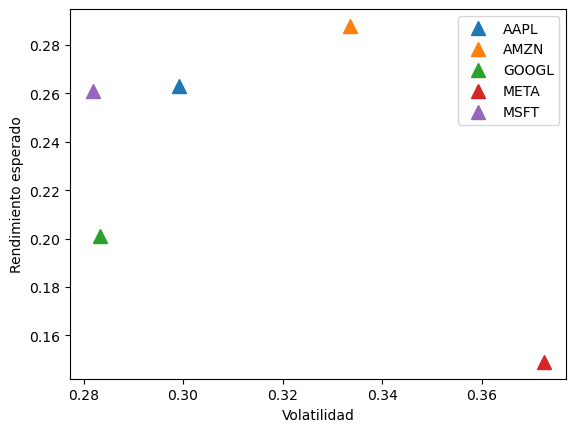

In [53]:
# Gráfico rendimiento esperado vs. volatilidad
for col in summary_annual:
    plt.plot(
        summary_annual.loc["vol", col],
        summary_annual.loc["media", col],
        "^",
        ms=10,
        label=col
    )
plt.legend()
plt.xlabel("Volatilidad")
plt.ylabel("Rendimiento esperado")

### 2.1 Ajuste de curvas con mínimos cuadrados
Consideramos que tenemos un conjunto de n pares ordenados de datos $(\sigma_{r_i},E[r_i])$, para $i=1,2,3,\dots,n$... **en este caso corresponden a volatilidad y rendimiento esperado**

#### ¿Cuál es la recta que mejor se ajusta a estos datos?
Consideramos entonces ajustes de la forma $\hat{f}(\sigma) = \beta_0+\beta_1 \sigma = \left[1 \quad \sigma\right]\left[\begin{array}{c} \beta_0 \\ \beta_1 \end{array}\right]=\left[1 \quad \sigma\right]\boldsymbol{\beta}$ (lineas rectas).

Para decir '*mejor*', tenemos que definir algún sentido en que una recta se ajuste *mejor* que otra.

**Mínimos cuadrados**: el objetivo es seleccionar los coeficientes $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$, de forma que la función evaluada en los puntos $\sigma_{r_i}$ ($\hat{f}(\sigma_{r_i})$) aproxime los valores correspondientes $E[r_i]$.

La formulación por mínimos cuadrados, encuentra los $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$ que minimiza
$$\sum_{i=1}^{n}(E[r_i]-\hat{f}(\sigma_{r_i}))^2$$

In [ ]:
# Importar el módulo optimize de la librería scipy


In [ ]:
# Funcion minimize


In [ ]:
# Funcion objetivo y condicion inicial


In [ ]:
# Resolver problema de optimizacion


In [ ]:
# Cálculo de bondad de ajuste através de R^2


**¿Qué se puede concluir acerca de la relación entre riesgo (medido con la volatilidad) y el rendimiento esperado (medido con la media)?**

Respuestas:
- La pendiente de la recta es positiva, lo que confirma la relación positiva entre rendimiento esperado y riesgo.
- Si el mercado solo estuviera dado por los cuatro activos analizados (GOOGL, MSFT, AAPL, AMZN), la tasa libre de riesgo sería $-0.19$.
- Por cada unidad de riesgo (volatilidad), el rendimiento esperado aumenta $1.61$.

## 3. Comentarios finales acerca del uso de datos históricos.

### ¡Cuidado!
- Es cierto que los patrones que vemos sobre periodos largos de tiempo en diferentes tipos de intrumentos son muy robustos en términos de la relación rendimiento/riesgo (positiva).
- Por tanto, esperamos rendimientos más altos en el futuro cuando asumimos cierto riesgo.
- ¿Cómo encontramos ese 'rendimiento esperado'? Datos históricos (humanos: tendencia a generalizar)

- Entonces, la idea es que si los rendimientos esperados son un p.e. estacionario, el promedio de muchos rendimientos pasados es una buena estimación del rendimiento esperado futuro (Teorema del límite central).
- ¿Deberíamos pensarlo dos veces?

## SI

Problemas:
- La muestra de datos en el periodo específico de tiempo puede estar sesgada.
- Ventanas de tiempo más grandes reducen especificidad de la muestra y estimados más precisos.
 - Aún así, datos muy viejos pueden ser no representativos.
- Nuevos fondos o estrategias de inversión están a menudo sesgados positivamente:
 - reporte de resultados en tiempos voluntarios;
 - las que mueren (no funcionan), no se reportan;

# Anuncios parroquiales:
## 1. Fin Módulo 1. Revisar que se hayan cumplido los objetivos del módulo (Clase0)
## 2. Tarea: revisar archivo "Tarea3_MidiendoRendimientoRiesgo" en clase. Para el lunes 14 de febrero.
## 3. Recordar quiz la siguiente clase.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>